# Building a Model to Build a Better Team
#### Can we use a team's performance the previous year to predict who they will take in the first round of the upcoming NFL draft?

In [39]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression

I've compiled a .csv file, draft_rankings.csv, that spans 7 NFL seasons (still adding to the list), detailing the offensive and defensive ranking, sorted by yards gained and allowed, respectively. The final column denotes which side of the ball that their first draft pick played. For teams with multiple first round draft picks, I've only included their first pick.

I took this coarse statistical view to avoid contamination from similar statistics (e.g. total yards, passing yards, rushing yards). This seems like the most reasonable first pass approach.

In [40]:
pd.read_csv("draft_rankings.csv").head()

,Team,Year,Orank,Drank,IsOffense
0,Arizona Cardinals,2008,4,19,1.0
1,Atlanta Falcons,2008,6,24,0.0
2,Baltimore Ravens,2008,18,2,1.0
3,Buffalo Bills,2008,25,14,0.0
4,Carolina Panthers,2008,10,18,NaN


In [3]:
all_teams=pd.read_csv("draft_rankings.csv")
picks=all_teams.dropna()
print picks.head()

                 Team  Year  Orank  Drank  IsOffense
0   Arizona Cardinals  2008      4     19        1.0
1     Atlanta Falcons  2008      6     24        0.0
2    Baltimore Ravens  2008     18      2        1.0
3       Buffalo Bills  2008     25     14        0.0
6  Cincinnati Bengals  2008     32     12        1.0


Load in the relevant data and omit teams with no first round draft pick from the model:

In [4]:
df = pd.DataFrame(picks, columns=['Orank', 'Drank', 'IsOffense'])
data_array = df.as_matrix()
print df.head()

   Orank  Drank  IsOffense
0      4     19        1.0
1      6     24        0.0
2     18      2        1.0
3     25     14        0.0
6     32     12        1.0


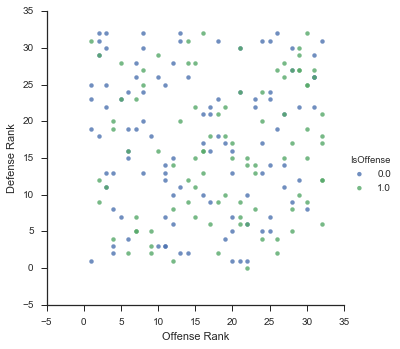

In [5]:
sns.set_context("notebook", font_scale=1.1)
sns.set(style="ticks")
sns.lmplot('Orank', 'Drank', data=df, hue='IsOffense', fit_reg=False) #x_jitter=.15, y_jitter=.15)
plt.xlabel("Offense Rank")
plt.ylabel("Defense Rank")
plt.show()

2D scatter plot doesn't show strong clusters of tendencies. Bad defensive teams still pick offensive guys, and vice versa. Most interesting regions are top left and bottom right (the poles). Intriguingly, why do teams with great defenses not seem to have terrible offenses? This is yards allowed, after all...

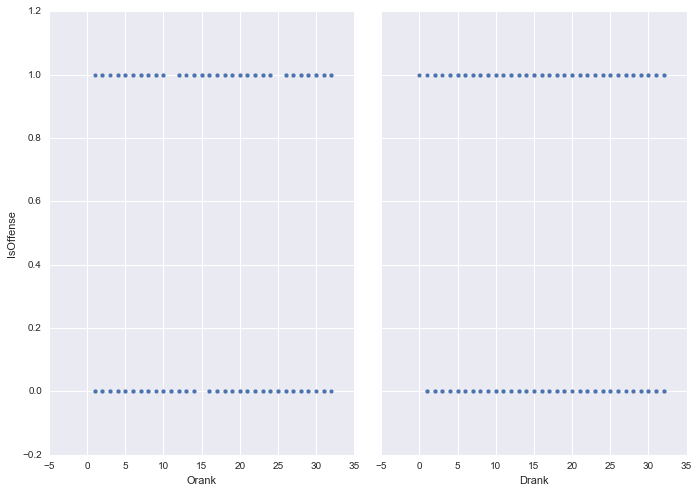

In [42]:
sns.set_context("notebook", font_scale=1.1)
sns.set(style="darkgrid")
#sns.lmlplot(x='Orank', y='IsOffense', data=df, logistic=True)
sns.pairplot(df, x_vars=['Orank', 'Drank'], y_vars='IsOffense', size=7, aspect=0.7)
plt.show()

Maybe a logistic regression could show some tendencies. Orrrrr not. Time to split the data into training and test sets to see if machine learning can uncover anything invisible to the eye.

In [44]:
stats = data_array[:, 1:3]
draftpick = data_array[:,2]
rankings=pd.DataFrame(picks, columns=['Orank', 'Drank'])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(rankings, draftpick, test_size=0.25, random_state=0)

X_train.shape, y_train.shape


((149, 2), (149,))

I like the thought of a KNN approach here. Though a pattern doesn't seem too apparent from the 2D scatter plot above, local clustering could be predictive. Or, general probability (3/5 might not be very obvious visually, but could be useful for modeling)...

In [46]:
n_neighbors = 5
#cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
#cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
#nbrs = NearestNeighbors(n_neighbors=n_neighbors,algorithm='ball_tree').fit(X_train)
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X_train, y_train)
clf.score(X_test, y_test) 

0.56000000000000005

Well that's not very good. After playing with the number of nearest neighbors, it's pretty apparent that this isn't a much more useful approach than flipping a coin.

In [47]:
clf.predict([[10, 1]])

array([ 1.])

In [48]:
model = LogisticRegression()
model = model.fit(X_train, y_train)
model.score(X_train, y_train)


0.57718120805369133

Overall, it looks like logistic regression is SLIGHTLY better than KNN. Nevertheless, about the best I can get is 60% accuracy (usually by dropping defense from the model, oddly. Maybe teams are more sensitive to total yard shortcomings on the offensive side of the ball).

#### To Do:
1. Augment dataset to increase sampling. Could reduce stochasticity in data.
2. Slice statistics to a more granular level (passing yards, rushing yards, tackles, turnovers). Skeptical about the ROI here, though.
3. Look at "expert predictions". There's a lot that this method ignores: free agency, retirement, devastating injuries, etc., that could influence the way a team will pick. 
4. Add which draft pick the team had to the data set. Does the model hold up better for the first few picks, and then fall apart when teams start taking the best remaining player, regardless of need?